# Defining and loading data

### Preprocessing:

##### Loading custiom modules

In [1]:
#!/bin/env python3.7

# load custom modules required for CLR training
from modules.TransformerEncoder import Transformer
from modules.ContrastiveLosses import clr_loss,anomclr_loss,anomclr_plus_loss
from modules.EventLevelAnomalyAugmentations import rotate_events ,collinear_fill_jets

from modules.my_jet_augs import rotate_jets, distort_jets, rescale_pts, crop_jets, translate_jets, collinear_fill_jets, collinear_fill_jets_fast , shift_pT ,pt_reweight_jet, drop_constits_jet



# import args from extargs.py file
import My_Anom_extargs as args



# load standard python modules
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

#starting counter
t0 = time.time()

# initialise logfile
logfile = open("/remote/gpu05/rueschkamp/outputs_from_queue/AnomCLR/Debugging/my_debug_logfile.txt", "a" )
print( "logfile initialised"   )

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
print( "device: " + str( device )    )

#loading in data ------------------------------------------------------------

sys.path.insert(1, '/remote/gpu05/rueschkamp/projects/torch_datasets/')
from top_dataset import My_Dataset
from semi_dataset import SemiV_Dataset
from torch.utils.data import DataLoader


#starting training loader --------------------------------------
n_jets = 1e4
ratio = 0.2
n_constits = 50

training_set = SemiV_Dataset(
                                    data_path =args.data_path,
                                    signal_origin= "qcd",
                                    usage= "training",
                                    number_constit=  n_constits,#args.n_constit,
                                    number_of_jets= n_jets,
                                    ratio = ratio
                                    )

dl_training = DataLoader(training_set,batch_size=args.batch_size, shuffle=True)

t1 = time.time()
print( "time taken to load and preprocess data: "+str( np.round( t1-t0, 2 ) ) + " seconds"    )


#initializing the network 
input_dim = 3 

net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt )
# send network to device
net.to( device );

logfile initialised
device: cuda
time taken to load and preprocess data: 3.21 seconds


# Training Loop 

## AnomCLR

### Loading Model

In [30]:
loading_model = True
if loading_model :
    # Create an instance of your model
    net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt )

    # Load the saved state dictionary
    #state_dict = torch.load("/remote/gpu05/rueschkamp/outputs_from_queue/AnomCLR/Model_21epochs_1e+04Jets.pt")
    epochs = 10
    n_jets =1e5
    Transformer_filename = f"/remote/gpu05/rueschkamp/outputs_from_queue/AnomCLR/Model_{epochs}epochs_{n_jets:.0e}Jets.pt"
    state_dict = torch.load(Transformer_filename)
    # Load the state dictionary into the model
    net.load_state_dict(state_dict)
    net.to(device)
    net.eval()

### Training Model

In [2]:
print( "starting training loop, running for " + str( args.n_epochs ) + " epochs"    )
print( "---"    )

losses = []

epochs = 10
breaker = 1
# the loop
#for epoch in range( args.n_epochs ):
for epoch in range( epochs):
    # initialise timing stats
    losses_e = []
    print("epoch: ",epoch)
    for i, (data, labels) in enumerate(dl_training):
        net.optimizer.zero_grad()
        x_i = data
        
        # print(x_i.shape) # checking what Tensor is fed into the augmentations
        x_i = rotate_jets( x_i ) # to undo the previos centring
        x_j = x_i.clone()
        x_k = x_i.clone()


        # POSITIVE AUGMENTATIONS
        x_j = rotate_jets( x_j ) 
        x_j = collinear_fill_jets_fast( x_j )
        x_j = collinear_fill_jets_fast( x_j ) #Why two times?
        x_j = distort_jets( x_j, strength=args.ptst, pT_clip_min=args.ptcm )

        x_i = translate_jets( x_i, width=args.trsw )
        x_j = translate_jets( x_j, width=args.trsw )
        x_k = translate_jets( x_k, width=args.trsw ) # what if we would skip this?

        x_i = rescale_pts( x_i )
        x_j = rescale_pts( x_j )
        # NEGATIVE AUGMENTATIONS
        
        #x_k = pt_reweight_jet( x_k)
        x_k = drop_constits_jet(x_k,0.3)

        # Getting representations
        
        x_i = x_i.transpose(1,2)
        x_j = x_j.transpose(1,2)
        x_k = x_k.transpose(1,2)
        
        z_i  = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask) #dim: x_i = torch.Size([104, 50, 3]) and z_i = torch.Size([104, 1000])
        z_j = net(x_j, use_mask=args.mask, use_continuous_mask=args.cmask)
        z_k = net(x_k,use_mask = args.mask, use_continuous_mask = args.cmask)

        if torch.isnan(z_k).any():
            
            print("Representation, Size:",z_k.size(),'Full Tensor:',z_k )
            print("x_i, Size:",x_k.size(),'Full Tensor:',x_k  )
            breaker = 0
        # compute the loss, back-propagate, and update scheduler if required
        loss = anomclr_plus_loss( z_i, z_j, z_k,args.temperature ).to( device )
        loss.backward()
        net.optimizer.step()
        losses_e.append( loss.detach().cpu().numpy() )
        
        if breaker==0:
            break
        #print(loss)
    if breaker==0:
            break    
        
    
    loss_e = np.mean( np.array( losses_e ) )
    print(loss_e)
    losses.append( loss_e )

starting training loop, running for 10 epochs
---
epoch:  0
0.008134833
epoch:  1
-0.088546075
epoch:  2
-0.519881
epoch:  3
-1.7443038
epoch:  4
-2.243597
epoch:  5
-3.0038338
epoch:  6
-2.3670266
epoch:  7
-0.097710624
epoch:  8
-0.6499544
epoch:  9
-0.8902052


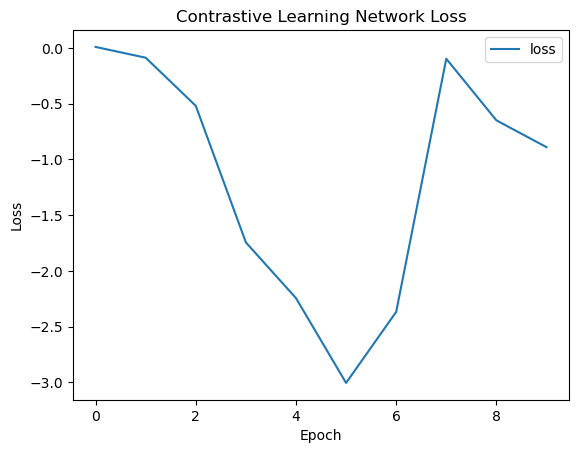

In [3]:
# Plot the training loss
x = np.linspace(0,epochs-1,epochs)
#print(z_k)
plt.plot(x, losses, label = "loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Contrastive Learning Network Loss')
plt.legend()
plt.show()


### Saving the Model

In [29]:
tms0 = time.time()

filename = f"/remote/gpu05/rueschkamp/outputs_from_queue/AnomCLR/Debugging/Model_{epochs}epochs_{n_jets:.0e}Jets.pt"
torch.save(net.state_dict(), filename)
tms1 = time.time()
print( f"time taken to save model: {round( tms1-tms0, 1 )}s" )

time taken to save model: 4.5s


# AE


## Loading Data and Creating AE

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, 8)
        )
        
        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(True),
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1000),
            #nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder()
model.to(device);

## Training

In [5]:
import collections
from tqdm import tqdm, tqdm_notebook # for the progress bar


net.eval()
model=Autoencoder()
model.to(device)

criterion=nn.MSELoss()
learning_rate = 1e-3
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

# Utilize a named tuple to keep track of scores at each epoch
model_hist = collections.namedtuple('Model','epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])

def train(epochs, model, model_loss,train_dataloader):
    try: c = model_loss.epoch[-1]
    except: c = 0
    for epoch in tqdm_notebook(range(epochs),position=0, total = epochs):
        epoch_loss = 0.0
        num_batches = 0

        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            #preprocess
            x_i = inputs
            time1 = time.time()
            x_i = x_i.transpose(1,2) 
            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )



            outputs = model(point_on_sphere)
            loss = criterion(outputs, point_on_sphere)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(loss.item())
        t = time.time()
        print(f"Epoch {epoch}: loss={epoch_loss:.4f} time taken{round(t1-t,2)}")

epochs = 10

train(model =model , epochs = epochs, model_loss =model_loss,train_dataloader=dl_training) #AE

/tmp/ipykernel_3163978/871980278.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),position=0, total = epochs):


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: loss=0.0087 time taken-322.86
Epoch 1: loss=0.0007 time taken-333.27
Epoch 2: loss=0.0000 time taken-344.34
Epoch 3: loss=0.0000 time taken-356.33
Epoch 4: loss=0.0000 time taken-366.34
Epoch 5: loss=0.0000 time taken-379.06
Epoch 6: loss=0.0000 time taken-391.26
Epoch 7: loss=0.0000 time taken-403.65
Epoch 8: loss=0.0000 time taken-416.09
Epoch 9: loss=0.0000 time taken-428.23


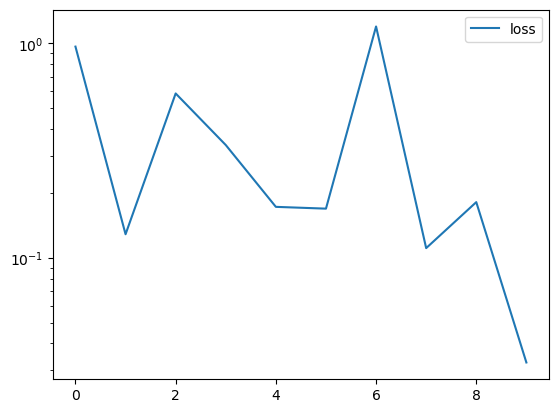

In [33]:
x = np.linspace(0, epochs-1 , epochs)
plt.plot(x, model_loss.loss, label="loss")
plt.yscale("log")
plt.legend()

## Verification

In [7]:
n_jets = 10000
testing_set_aachen = SemiV_Dataset(
                                    data_path =args.data_path,
                                    signal_origin= "aachen",
                                    usage= "testing",
                                    number_constit= args.n_constit,
                                    number_of_jets= n_jets,
                                    ratio = ratio
                                    )

dl_AE_testing_aachen = DataLoader(testing_set_aachen,batch_size=args.batch_size, shuffle=False)

testing_set_heidelberg = SemiV_Dataset(
                                    data_path =args.data_path,
                                    signal_origin= "heidelberg",
                                    usage= "testing",
                                    number_constit= args.n_constit,
                                    number_of_jets= n_jets,
                                    ratio = ratio
                                    )

dl_AE_testing_heidelberg = DataLoader(testing_set_heidelberg,batch_size=args.batch_size, shuffle=False)

testing_set_top = My_Dataset("/remote/gpu05/rueschkamp/data/Jandata/Zendoo/train.h5",
                                  "/remote/gpu05/rueschkamp/data/Jandata/Zendoo/val.h5",
                                  "/remote/gpu05/rueschkamp/data/Jandata/Zendoo/test.h5",
                                  "testing",
                                  50,
                                  number_of_jets= n_jets)

dl_AE_testing_top = DataLoader(testing_set_top,batch_size=args.batch_size, shuffle=False)

print(len(dl_AE_testing_heidelberg))

32


In [8]:
criterion =nn.MSELoss()

def calculate_errors(model, criterion, dataloader):
    errors = []
    model.eval() # set model to evaluation mode

    with torch.no_grad(): # turn off gradients since we're only evaluating
        for inputs, label in dataloader:
            x_i = inputs

            x_i =  x_i.transpose(1,2)

            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )
            outputs = model(point_on_sphere)
            #print(point_on_sphere.shape)
            #outputs = sigmoid(model(point_on_sphere))
            for i in range(len(point_on_sphere)):
                
                loss = criterion(outputs[i], point_on_sphere[i]) 
                errors.extend([loss.to(torch.device("cpu")).numpy()])

    return np.array(errors)

def get_true_labels(data_loader):
    labels = []
    for batch in data_loader:
        _, batch_labels = batch
        labels.extend(batch_labels.to(torch.device("cpu")).numpy().tolist())
    return np.array(labels)

output_net_aachen = calculate_errors(model ,criterion, dl_AE_testing_aachen)
labels_net_aachen = get_true_labels(dl_AE_testing_aachen)

print(output_net_aachen)
print(labels_net_aachen)

[1.06887637e-05 1.06079882e-04 1.23665832e-05 ... 3.75670425e-05
 1.51203185e-05 1.82571443e-04]
[0. 0. 0. ... 1. 1. 1.]


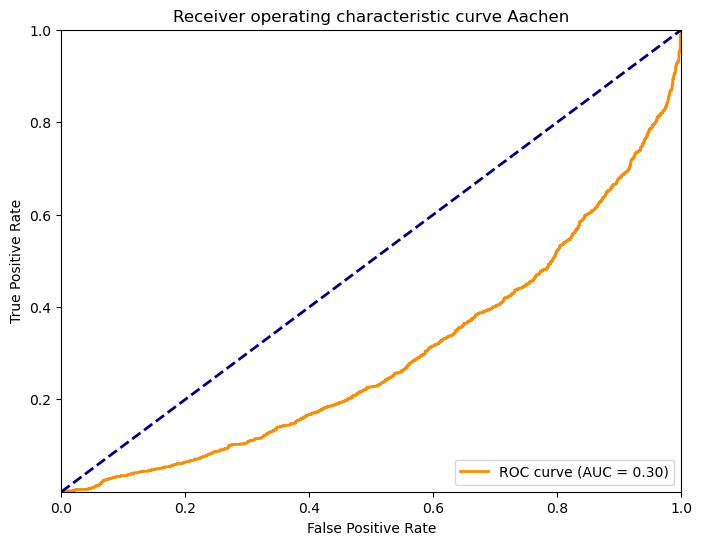

In [9]:
fpr, tpr, thresholds = roc_curve(labels_net_aachen, output_net_aachen) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve Aachen')
plt.legend(loc="lower right")
plt.show()

#### Heidelberg

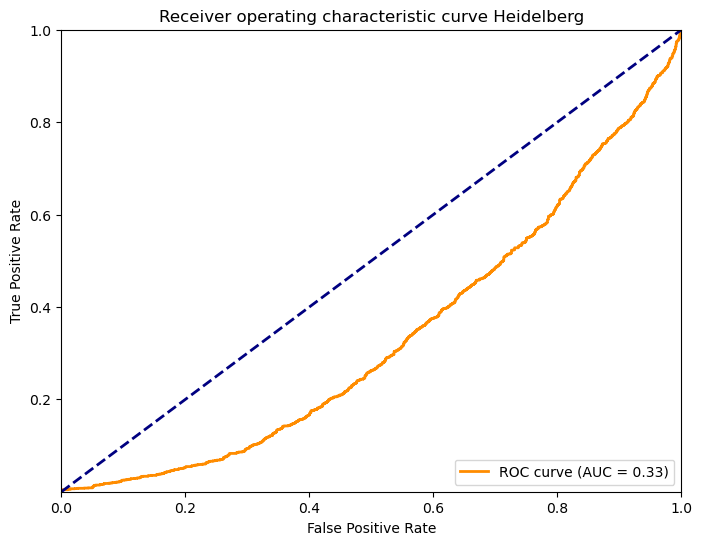

In [10]:
output_net_heidelberg = calculate_errors(model ,criterion, dl_AE_testing_heidelberg)
labels_net_heidelberg = get_true_labels(dl_AE_testing_heidelberg)

fpr, tpr, thresholds = roc_curve(labels_net_heidelberg, output_net_heidelberg) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve Heidelberg')
plt.legend(loc="lower right")
plt.show()

#### Top


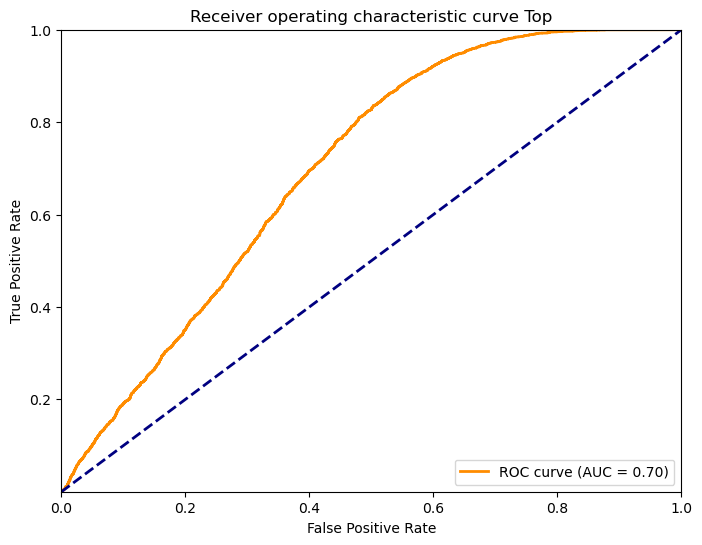

In [11]:
output_net_top = calculate_errors(model ,criterion, dl_AE_testing_top)
labels_net_top = get_true_labels(dl_AE_testing_top)

fpr, tpr, thresholds = roc_curve(labels_net_top, output_net_top) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve Top')
plt.legend(loc="lower right")
plt.show()

# Checking stuff


In [14]:
data_path = "/remote/gpu05/rueschkamp/data/Luidata/datasets/qcd_constit.h5"
data_frame = pd.read_hdf(data_path, key='table', start=0, stop=1)
data_frame

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,PZ_197,E_198,PX_198,PY_198,PZ_198,E_199,PX_199,PY_199,PZ_199,is_signal_new
0,21.629394,-10.332255,12.956715,-13.899595,21.138103,-8.645403,13.655065,-13.624082,20.641938,-10.110924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
mean= []

for i,(data,labels) in enumerate(dl_training):

    x = data
    pTs_mean = torch.mean(x[:,0,:])
    mean.append(pTs_mean.cpu())
    

    

In [9]:
print(len(mean))
print(np.mean(mean))

79
3.7667983


In [3]:
!nvidia-smi

Mon May 15 09:46:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   48C    P2    50W / 250W |   1444MiB / 11264MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:06:00.0 Off |                  N/A |
|  0%   

-9